# GRU Time Series Forecasting of Neuralink Dataset


## Imports


In [120]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from glob import glob
import scipy.io
import IPython
import time
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import math
from scipy.io import wavfile

### Function Definitions


In [239]:
WINDOW_SIZE = 200

In [240]:
def create_train_test_set(data, window_size):
    raw_data = data.to_numpy()  # convert to numpy array
    data = []

    # create all possible sequences of length window_size using the
    # sliding window method
    for current_index in range(len(raw_data) - window_size):
        data.append(raw_data[current_index : current_index + window_size])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

In [241]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.output_layer(out[:, -1, :])
        return out

## Multi-layer Gated Recurrent Unit Recurrent Neural Network (GRU)


### Importing Data & Normalizing the Neural Data


In [242]:
data_dir = "../../data/"
data_file_l = glob(data_dir + "*.wav")
rate, data = wavfile.read(data_file_l[0])
df = pd.DataFrame(data, columns=["Amplitude"])
df.index.name = "Sample"

In [243]:
# The values are normalized between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
df["Amplitude"] = scaler.fit_transform(df["Amplitude"].values.reshape(-1, 1))

### Splitting the Data into Training & Testing Sets


In [245]:
x_train, y_train, x_test, y_test = create_train_test_set(df, window_size=WINDOW_SIZE)

In [246]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [247]:
x_train.shape

torch.Size([78799, 199, 1])

In [248]:
x_test.shape

torch.Size([19700, 199, 1])

#### Defining the Neural Network


In [249]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = GRU(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
)

criterion = nn.MSELoss(reduction="mean")
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

#### Training the Neural Network


In [250]:
hist = np.zeros(num_epochs)

In [251]:
# %%time
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

#### Reformatting the Data


In [133]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

In [134]:
result_df = pd.concat([original, predict], axis=1)
result_df.columns = ["Truth", "Training Pred"]
result_df.index.name = "Sample"
result_df["Residuals"] = result_df["Truth"] - result_df["Training Pred"]
result_df.head()

,Truth,Training Pred,Residuals
Sample,,,
0,736.0,1209.649780,-473.649780
1,672.0,796.712280,-124.712280
2,1376.0,736.484131,639.515869
3,1120.0,1297.948853,-177.948853
4,1376.0,1084.566040,291.433960


In [135]:
result_df.loc[(result_df["Residuals"] > -1) & (result_df["Residuals"] < 1)]

,Truth,Training Pred,Residuals
Sample,,,
49,415.000000,415.135986,-0.135986
700,1248.000000,1247.778442,0.221558
1403,-1249.000000,-1249.965088,0.965088
2314,1697.000000,1697.246338,-0.246338
3142,1184.000000,1183.127319,0.872681
...,...,...,...
75627,-288.000031,-287.184540,-0.815491
75963,608.000000,607.561951,0.438049
76892,1376.000000,1376.836304,-0.836304


In [136]:
result_df.__len__()

78943

##### Plotting the Training Predictions


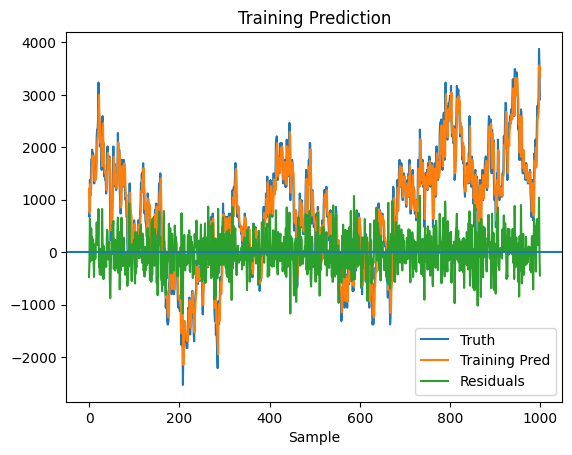

In [137]:
result_df.head(1000).plot()
plt.axhline(y=0)
plt.title("Training Prediction")
plt.show()

#### Making Predictions Using the Test Data


In [138]:
x_test.shape

torch.Size([19736, 19, 1])

In [139]:
# Make Predictions
y_test_pred = model(x_test)

In [140]:
# Invert Predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

##### Calculate Root Mean Squared Error


In [141]:
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
print("Test Score: %.2f RMSE" % (testScore))
gru.append(trainScore)
gru.append(testScore)

Train Score: 382.47 RMSE
Test Score: 383.22 RMSE


##### Shift Predictions for Plotting


In [148]:
window_size = WINDOW_SIZE

In [154]:
trainPredictPlot.shape

(98699, 1)

In [157]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size : len(y_train_pred) + window_size, :] = y_train_pred

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred) + window_size - 1 : len(data) - 1, :] = y_test_pred

original = scaler.inverse_transform(df.values.reshape(-1, 1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

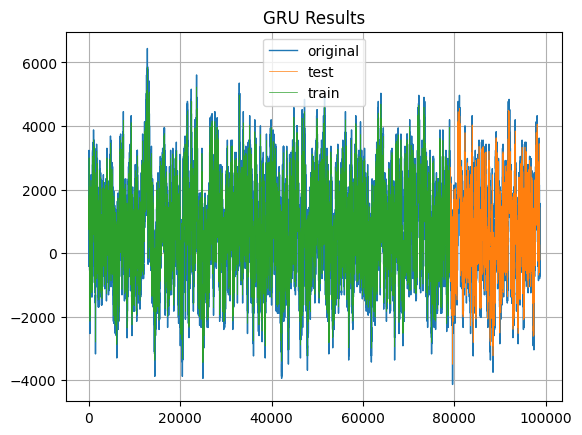

In [179]:
plt.title("GRU Results")
plt.plot(result.index, result[2], label="original", linewidth=1)
plt.plot(result.index, result[1], label="test", linewidth=0.5)
plt.plot(result.index, result[0], label="train", linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()

#### Comparing Test Results with Ground Truth Values


In [192]:
sub_ground_truth_values = result[2][result[1] > 0]

In [193]:
sub_test_values = result[1][result[1] > 0]

In [194]:
sub_ground_truth_values

78962    1440.0
78963    1376.0
78964    1504.0
78965    2017.0
78966    1889.0
          ...  
98690     351.0
98691     672.0
98692     544.0
98693    -160.0
98697     223.0
Name: 2, Length: 14287, dtype: float64

In [195]:
sub_df = pd.concat([sub_ground_truth_values, sub_test_values], axis=1)
sub_df.columns = ["Ground Truth", "Test Predictions"]

In [196]:
sub_df["Residuals"] = sub_df["Ground Truth"] - sub_df["Test Predictions"]

In [197]:
sub_df

,Ground Truth,Test Predictions,Residuals
78962,1440.0,1444.718506,-4.718506
78963,1376.0,1557.914795,-181.914795
78964,1504.0,1455.853149,48.146851
78965,2017.0,1525.004761,491.995239
78966,1889.0,1933.015747,-44.015747
...,...,...,...
98690,351.0,942.269470,-591.269470
98691,672.0,473.135529,198.864471
98692,544.0,718.263428,-174.263428
98693,-160.0,583.788330,-743.788330


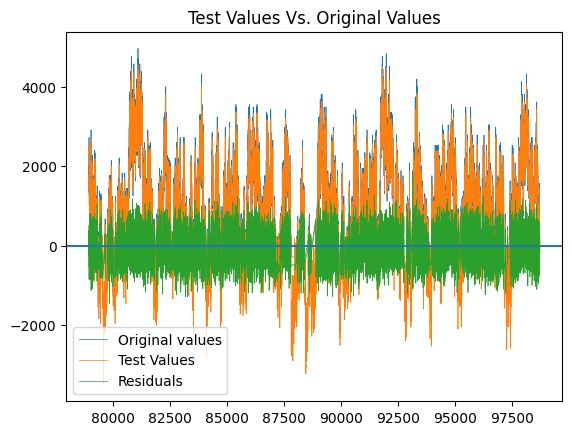

In [204]:
plt.title("Test Values Vs. Original Values")
plt.plot(
    result[2][result[1] > 0].index,
    result[2][result[1] > 0],
    label="Original values",
    linewidth=0.5,
)
plt.plot(result[1], label="Test Values", linewidth=0.5)
plt.plot(sub_df["Residuals"], label="Residuals", linewidth=0.5)
plt.axhline(y=0)
plt.legend()
plt.show()

In [210]:
sub_df["Residuals"].loc[(sub_df["Residuals"] > -1) & (sub_df["Residuals"] < 1)]

79206    0.135864
79441   -0.713135
79888   -0.078735
80260    0.540039
80431    0.789978
81325   -0.958130
82350   -0.211792
82529   -0.585449
83162    0.724060
83425   -0.490112
83902   -0.541626
85358   -0.947998
86653    0.286865
86950    0.816284
86966   -0.786499
87750   -0.740845
90045   -0.719360
90312   -0.844238
90522    0.648453
91876   -0.180176
92080   -0.436523
92452    0.945557
92476    0.979492
92569    0.824127
94343   -0.785812
94607    0.672241
95099   -0.039536
95154   -0.513107
95490    0.890381
95524   -0.927246
95984   -0.350952
97475    0.262207
97641   -0.875183
97810    0.938477
97820   -0.536255
98278   -0.493164
Name: Residuals, dtype: float64

In [214]:
sub_df.__len__()

14287

In [226]:
percent_residuals_between_minus_one_and_one = (
    len(sub_df["Residuals"].loc[(sub_df["Residuals"] > -1) & (sub_df["Residuals"] < 1)])
    / sub_df.__len__()
) * 100

In [230]:
print(
    f"{percent_residuals_between_minus_one_and_one:.2f}% of the residuals are between -1 and 1."
)

0.25% of the residuals are between -1 and 1.


In [231]:
# There are no residuals that are equal to zero.
sub_df["Residuals"].loc[sub_df["Residuals"] == 0]

Series([], Name: Residuals, dtype: float64)

In [237]:
model.parameters()

<generator object Module.parameters at 0x322162a40>

In [238]:
torch.save(model, "neural_gru.pickle")